In [1]:
# Import libraries
import pandas as pd # Data management
import duckdb # Database management
import numpy as np # Numerical computations
import matplotlib.pyplot as plt # Data visualization
import seaborn as sns # Data visualization
from scipy.stats import ttest_ind, chi2_contingency # Statistical tests

In [2]:
# Connect to the database
con = duckdb.connect(database="icu_outcomes.duckdb")

# Load the table into a pandas DataFrame
df = con.execute("SELECT * FROM clean_data").fetchdf()

# Close the connection
con.close()

# Display the first few rows of the DataFrame
display(df.head())

,gender,admission_date,discharge_date,diagnosis,age_numeric,marital_status,religion,comorbidities,referral,referral_others_specify,...,surgery_before_during_admission,urinary_catheter,peripheral_catheter,central_venous_catheter,intubation,ng_tube,chest_tube,mortality,intubated,gcs_cleaned
0,Female,2022-04-08,2022-04-15,I31.3 - Pericardial effusion (noninflammatory)...,16,Never married/not in union,Christianity,Non-communicable,Others (specify),None,...,False,True,True,True,True,True,False,True,<NA>,<NA>
1,Female,2023-02-25,2023-03-02,"O15.2 - Eclampsia in the puerperium, D57.219 -...",26,Never married/not in union,Christianity,Non-communicable,O&G,None,...,True,True,True,False,False,False,False,False,False,15
2,Male,2021-01-27,2021-01-27,S06.5 - Traumatic subdural haemorrhage,40,Currently married/in union,Christianity,Non-communicable,MSW,None,...,False,True,True,False,True,True,False,True,False,3
3,Male,2021-05-24,2021-05-31,"I64 - Stroke, not specified as haemorrhage or ...",77,None,None,None,None,None,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,<NA>,<NA>
4,Female,2021-05-10,2021-05-15,"A02.1 - Salmonella sepsis, ASUR06A - Laparotom...",16,Never married/not in union,Christianity,Non-communicable,Main Theater Recovery Ward,None,...,True,True,True,True,True,True,False,True,False,14


In [3]:
# Identify missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
print("\nMissing Values:")
print(missing_values)
print("\nMissing Value Percentage:")
print(missing_percentage)


Missing Values:
gender                               0
admission_date                       0
discharge_date                       0
diagnosis                            0
age_numeric                          0
marital_status                     135
religion                           153
comorbidities                      140
referral                            71
referral_others_specify            621
antibiotic_treatment                63
surgery_before_during_admission     20
urinary_catheter                    52
peripheral_catheter                 44
central_venous_catheter             48
intubation                          39
ng_tube                             41
chest_tube                          39
mortality                            0
intubated                          165
gcs_cleaned                        178
dtype: int64

Missing Value Percentage:
gender                              0.000000
admission_date                      0.000000
discharge_date                    

In [4]:
# Convert date columns to datetime objects
df['admission_date'] = pd.to_datetime(df['admission_date'])
df['discharge_date'] = pd.to_datetime(df['discharge_date'])

# Calculate length of stay in days
df['length_of_stay_days'] = (df['discharge_date'] - df['admission_date']).dt.days

# Display the first few rows of the cleaned DataFrame and info
display(df.head())
display(df.info())

,gender,admission_date,discharge_date,diagnosis,age_numeric,marital_status,religion,comorbidities,referral,referral_others_specify,...,urinary_catheter,peripheral_catheter,central_venous_catheter,intubation,ng_tube,chest_tube,mortality,intubated,gcs_cleaned,length_of_stay_days
0,Female,2022-04-08,2022-04-15,I31.3 - Pericardial effusion (noninflammatory)...,16,Never married/not in union,Christianity,Non-communicable,Others (specify),None,...,True,True,True,True,True,False,True,<NA>,<NA>,7
1,Female,2023-02-25,2023-03-02,"O15.2 - Eclampsia in the puerperium, D57.219 -...",26,Never married/not in union,Christianity,Non-communicable,O&G,None,...,True,True,False,False,False,False,False,False,15,5
2,Male,2021-01-27,2021-01-27,S06.5 - Traumatic subdural haemorrhage,40,Currently married/in union,Christianity,Non-communicable,MSW,None,...,True,True,False,True,True,False,True,False,3,0
3,Male,2021-05-24,2021-05-31,"I64 - Stroke, not specified as haemorrhage or ...",77,None,None,None,None,None,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,<NA>,<NA>,7
4,Female,2021-05-10,2021-05-15,"A02.1 - Salmonella sepsis, ASUR06A - Laparotom...",16,Never married/not in union,Christianity,Non-communicable,Main Theater Recovery Ward,None,...,True,True,True,True,True,False,True,False,14,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   gender                           654 non-null    object        
 1   admission_date                   654 non-null    datetime64[us]
 2   discharge_date                   654 non-null    datetime64[us]
 3   diagnosis                        654 non-null    object        
 4   age_numeric                      654 non-null    int64         
 5   marital_status                   519 non-null    object        
 6   religion                         501 non-null    object        
 7   comorbidities                    514 non-null    object        
 8   referral                         583 non-null    object        
 9   referral_others_specify          33 non-null     object        
 10  antibiotic_treatment             591 non-null    boolean      

None

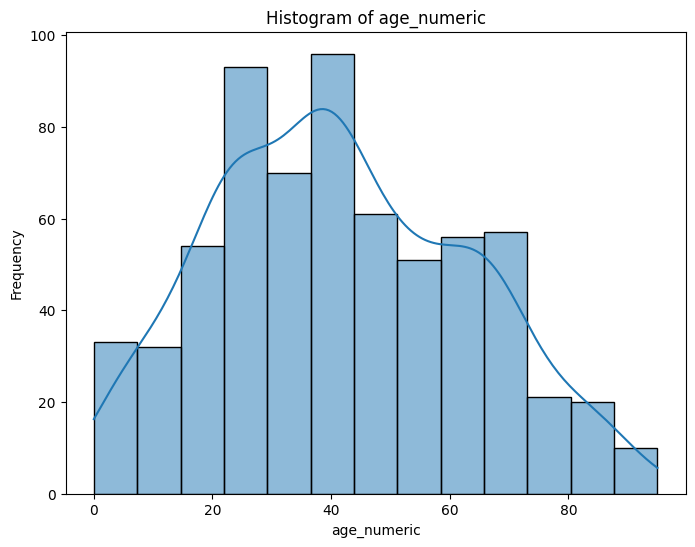

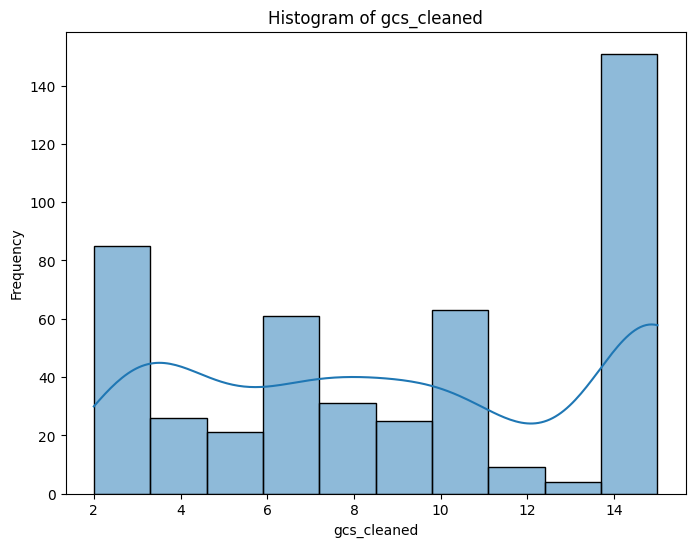

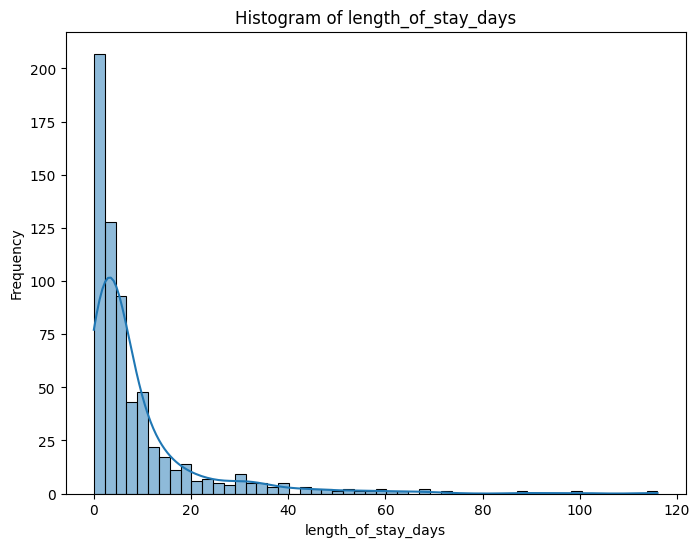

In [5]:
# Histogram of numeric variables
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Frequency')
    plt.show()

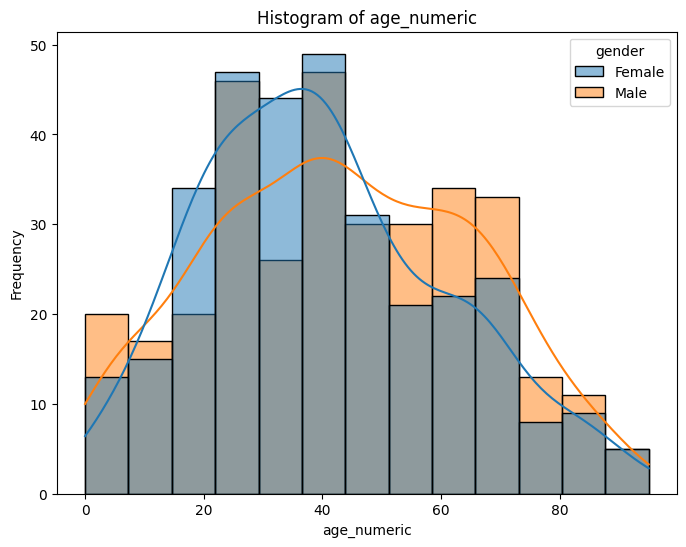

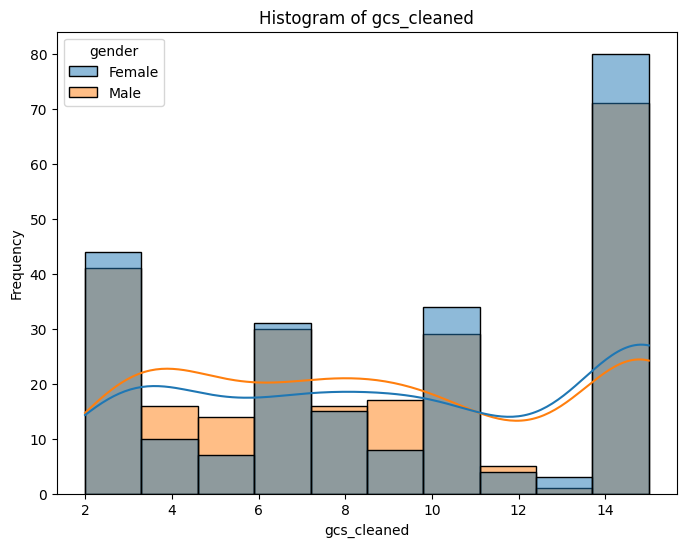

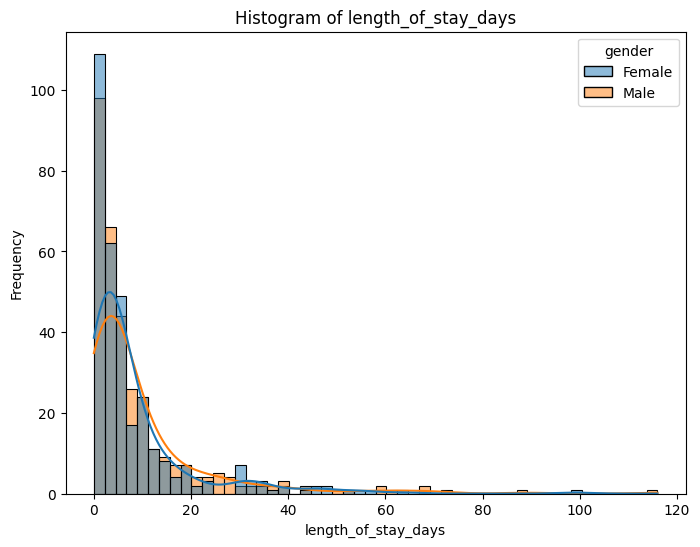

In [6]:
# Histogram of numeric variables by sex
for col in numeric_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x=col, kde=True, hue=df["gender"])
    plt.title(f'Histogram of {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Frequency')
    plt.show()


Distribution of gender:
gender
Male      332
Female    322
Name: count, dtype: int64

Distribution of marital_status:
marital_status
Currently married/in union    266
Never married/not in union    221
Widowed                        20
Divorced                       11
Separated                       1
Name: count, dtype: int64

Distribution of religion:
religion
Christianity            461
Islam                    36
Others (specify)          3
Traditional religion      1
Name: count, dtype: int64

Distribution of comorbidities:
comorbidities
Non-communicable                    467
Communicable                         21
Non-communicable  Communicable       15
Non-communicable  | Communicable     10
Communicable Non-communicable         1
Name: count, dtype: int64

Distribution of referral:
referral
A&E                             187
Main Theater Recovery Ward      100
External                         63
Others (specify)                 39
ETAT                             32
MSW     

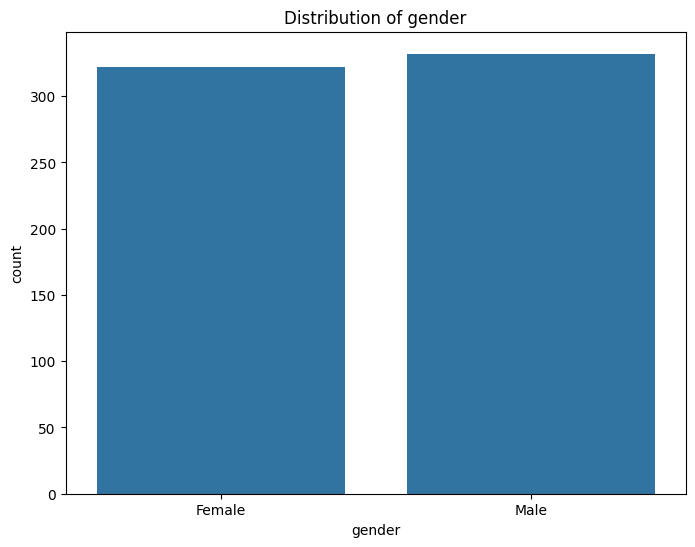

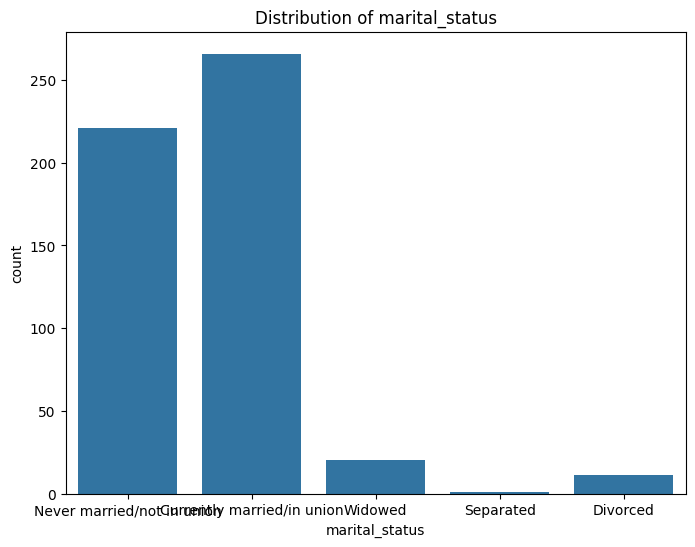

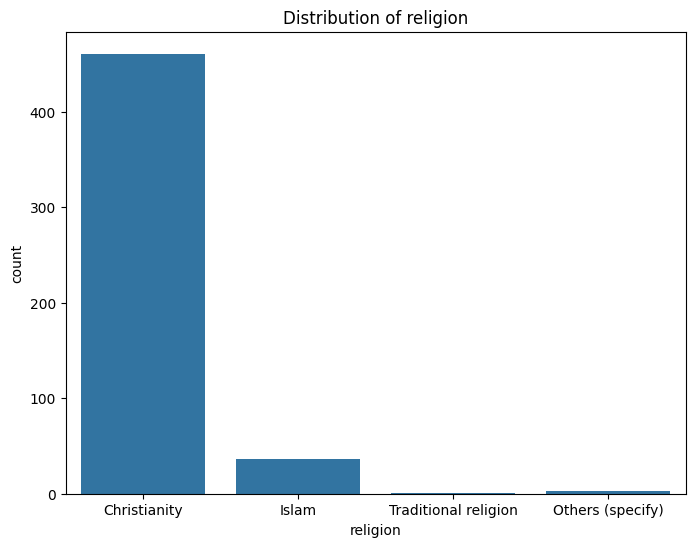

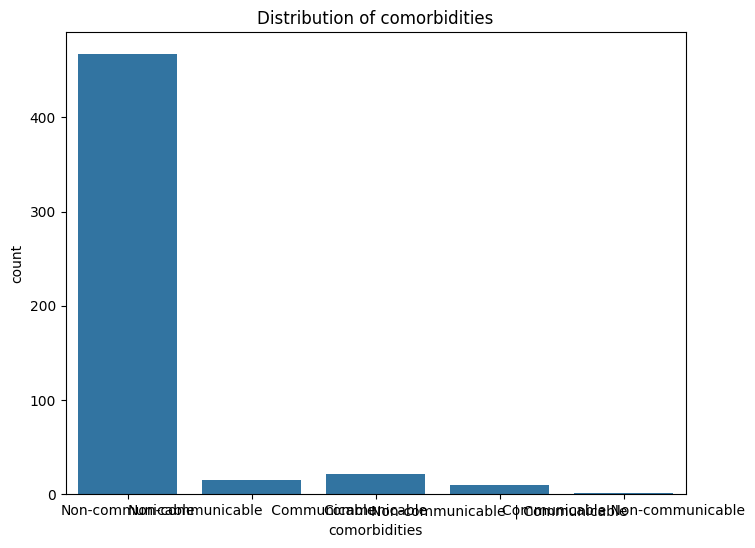

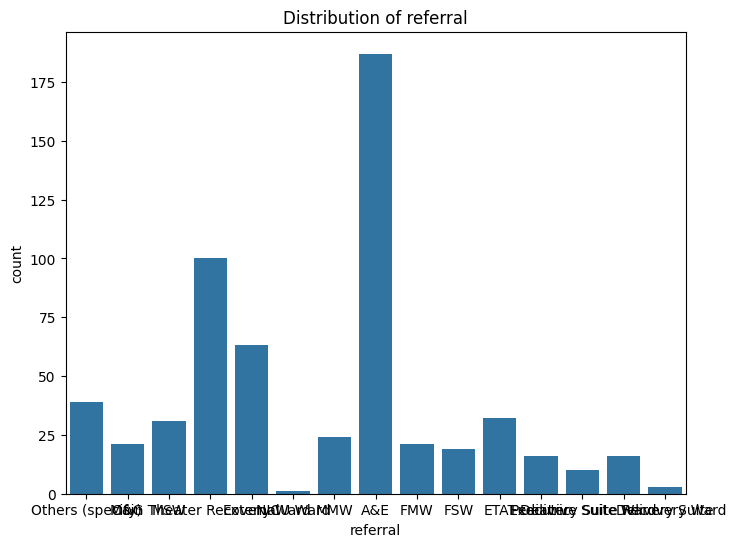

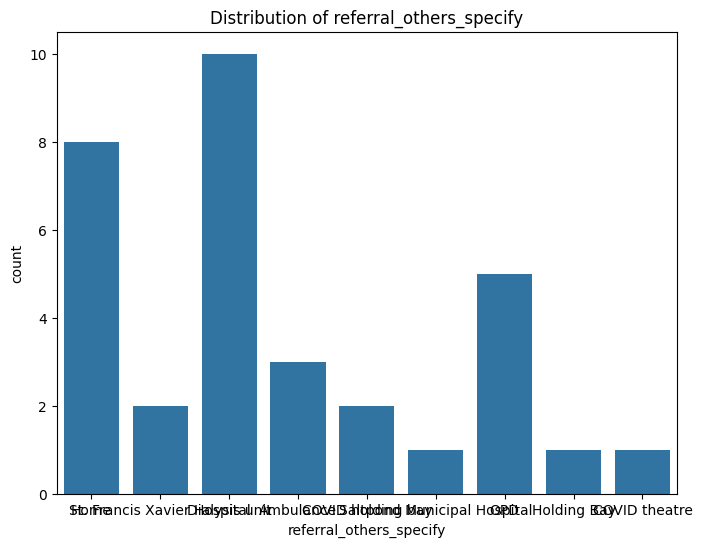

In [8]:
# Analyze the distribution of categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != "diagnosis":
        print(f"\nDistribution of {col}:")
        print(df[col].value_counts())
        # Bar plot
        plt.figure(figsize=(8, 6))
        sns.countplot(data=df, x=col)
        plt.title(f'Distribution of {col}')
        plt.xlabel(f'{col}')

In [ ]:
# Investigate the correlation between numerical features
correlation_matrix = df.corr(numeric_only=True)
display(correlation_matrix)

# Plot correlation matrix
plt.figure(figsize=(12,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Identify potential outliers
plt.figure(figsize=(12, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Box plot stratified by sex
plt.figure(figsize=(14, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col], hue=df["gender"])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate overall mortality prevalence
overall_mortality_prevalence = df['mortality'].mean()
print(f"Overall Mortality Prevalence: {overall_mortality_prevalence:.2f}")

In [ ]:
# Relationship between mortality and gender
print("\nMortality by Gender:")
mortality_by_gender = pd.crosstab(df['gender'], df['mortality'], normalize='index')
display(mortality_by_gender)

# Relationship between mortality and age group (need to define age groups first)
# For now, compare age distribution for deceased vs. survived
print("\nAge Distribution by Mortality:")
display(df.groupby('mortality')['age_numeric'].describe())

# Visualize age distribution by mortality
plt.figure(figsize=(10, 6))
sns.boxplot(x='mortality', y='age_numeric', data=df)
plt.title('Age Distribution by Mortality')
plt.xlabel('Mortality (False=Survived, True=Died)')
plt.ylabel('Age')
plt.show()

# Relationship between mortality and referral source
print("\nMortality by Referral Source:")
mortality_by_referral = pd.crosstab(df['referral'], df['mortality'], normalize='index')
display(mortality_by_referral.sort_values(by=True, ascending=False)) # Sort by mortality rate

# Relationship between mortality and selected clinical characteristics (boolean columns)
clinical_vars = ['antibiotic_treatment', 'surgery_before_during_admission',
                 'urinary_catheter', 'peripheral_catheter', 'central_venous_catheter',
                 'intubation', 'ng_tube', 'chest_tube', 'intubated']

print("\nMortality by Clinical Characteristics:")
for var in clinical_vars:
    if var in df.columns:
        print(f"\n{var}:")
        mortality_by_clinical = pd.crosstab(df[var], df['mortality'], normalize='index')
        display(mortality_by_clinical)

# Explore relationship with GCS (cleaned)
print("\nGCS Distribution by Mortality:")
display(df.groupby('mortality')['gcs_cleaned'].describe())

# Visualize GCS distribution by mortality
plt.figure(figsize=(10, 6))
sns.boxplot(x='mortality', y='gcs_cleaned', data=df)
plt.title('GCS Distribution by Mortality')
plt.xlabel('Mortality (False=Survived, True=Died)')
plt.ylabel('GCS (Cleaned)')
plt.show()

In [ ]:
# Relationship between length of stay and mortality
print("\nLength of Stay Distribution by Mortality:")
display(df.groupby('mortality')['length_of_stay_days'].describe())

# Visualize length of stay distribution by mortality
plt.figure(figsize=(10, 6))
sns.boxplot(x='mortality', y='length_of_stay_days', data=df)
plt.title('Length of Stay Distribution by Mortality')
plt.xlabel('Mortality (False=Survived, True=Died)')
plt.ylabel('Length of Stay (Days)')
plt.show()

# Relationship between length of stay and gender
print("\nMean Length of Stay by Gender:")
display(df.groupby('gender')['length_of_stay_days'].mean())

# Relationship between length of stay and age group (need to define age groups first)
# For now, examine correlation with numerical age
print("\nCorrelation between Length of Stay and Age:")
display(df[['length_of_stay_days', 'age_numeric']].corr())

# Visualize relationship between length of stay and age
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age_numeric', y='length_of_stay_days', data=df)
plt.title('Length of Stay vs. Age')
plt.xlabel('Age')
plt.ylabel('Length of Stay (Days)')
plt.show()


# Relationship between length of stay and selected clinical characteristics (boolean columns)
print("\nMean Length of Stay by Clinical Characteristics:")
for var in clinical_vars:
    if var in df.columns:
        print(f"\n{var}:")
        display(df.groupby(var)['length_of_stay_days'].mean())

# Relationship between length of stay and GCS (cleaned)
print("\nCorrelation between Length of Stay and GCS (cleaned):")
display(df[['length_of_stay_days', 'gcs_cleaned']].corr())

# Visualize relationship between length of stay and GCS (cleaned)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='gcs_cleaned', y='length_of_stay_days', data=df)
plt.title('Length of Stay vs. GCS (Cleaned)')
plt.xlabel('GCS (Cleaned)')
plt.ylabel('Length of Stay (Days)')
plt.show()

In [ ]:

# Hypothesis Test 1: GCS vs. Mortality (Independent Samples t-test)

# Separate GCS scores for patients who survived (mortality=False) and died (mortality=True)
gcs_survived = df[not df['mortality']]['gcs_cleaned'].dropna()
gcs_died = df[df['mortality']]['gcs_cleaned'].dropna()

# Perform independent samples t-test
ttest_result = ttest_ind(gcs_survived, gcs_died)

print("\nIndependent Samples T-test for GCS vs. Mortality:")
print(f"  Test Statistic: {ttest_result.statistic:.4f}")
print(f"  P-value: {ttest_result.pvalue:.4f}")

# Interpret the result
alpha = 0.05
if ttest_result.pvalue < alpha:
    print(f"  Result: Reject the null hypothesis. There is a statistically significant difference in mean GCS scores between patients who survived and those who died (p < {alpha}).")
else:
    print(f"  Result: Fail to reject the null hypothesis. There is no statistically significant difference in mean GCS scores between patients who survived and those who died (p >= {alpha}).")

# Hypothesis Test 2: Referral Source vs. Mortality (Chi-squared test)

# Create a contingency table of referral source and mortality
contingency_table = pd.crosstab(df['referral'], df['mortality'])

# Perform chi-squared test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\nChi-squared Test for Referral Source vs. Mortality:")
print(f"  Chi-squared Statistic: {chi2:.4f}")
print(f"  P-value: {p:.4f}")
print(f"  Degrees of Freedom: {dof}")

# Interpret the result
if p < alpha:
    print(f"  Result: Reject the null hypothesis. There is a statistically significant association between referral source and mortality (p < {alpha}).")
else:
    print(f"  Result: Fail to reject the null hypothesis. There is no statistically significant association between referral source and mortality (p >= {alpha}).")

In [ ]:
mask = df["length_of_stay_days"] <= 1
len(df[mask])

In [ ]:
# Extract year, month, and day of the week from admission_date
df['discharge_year'] = df['discharge_date'].dt.year
df['discharge_month'] = df['discharge_date'].dt.month
df['discharge_dayofweek'] = df['discharge_date'].dt.dayofweek # Monday=0, Sunday=6

# Filter out data for the year 2024
df_filtered = df[df['discharge_year'] != 2024].copy()

# Calculate mortality rate by year using the filtered data
mortality_by_year = df_filtered.groupby('discharge_year')['mortality'].mean().reset_index()

print("\nMortality by Year:")
display(mortality_by_year)

# Visualize mortality by year
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=mortality_by_year, x='discharge_year', y='mortality', color='skyblue') # Changed to barplot and set color
plt.title('Mortality Prevalence by Year (2019-2023)')
plt.xlabel('Year')
plt.ylabel('Mortality Prevalence')
plt.xticks(ticks=range(len(mortality_by_year)), labels=mortality_by_year['discharge_year'], rotation=45) # Set specific ticks and labels for barplot
plt.ylim(0, mortality_by_year['mortality'].max() * 1.2) # Adjusted y-axis limit for labels
plt.tight_layout()
# Add mortality rate values on each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0%}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

In [ ]:
# Calculate mortality rate by day of the week
mortality_by_dayofweek = df.groupby('discharge_dayofweek')['mortality'].mean().reset_index()

print("\nMortality by Day of the Week:")
display(mortality_by_dayofweek)

# Visualize mortality by day of the week
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=mortality_by_dayofweek, x='discharge_dayofweek', y='mortality', color='skyblue') # Changed to barplot and set color
plt.title('Mortality Prevalence by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Mortality Prevalence')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.ylim(0, mortality_by_dayofweek['mortality'].max() * 1.2) # Adjusted y-axis limit for labels
plt.tight_layout()
# Add mortality rate values on each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0%}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

In [ ]:
# Calculate mortality rate by month
mortality_by_month = df.groupby('discharge_month')['mortality'].mean().reset_index()

# Add month names for proper ordering in the plot
mortality_by_month['month_name'] = pd.to_datetime(mortality_by_month['discharge_month'], format='%m').dt.strftime('%b')

# Define the order of months
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

print("\nMortality by Month:")
display(mortality_by_month)

# Visualize mortality by month
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=mortality_by_month, x='month_name', y='mortality', order=month_order, color='skyblue') # Changed to barplot and set color, added order
plt.title('Mortality Prevalence by Month')
plt.xlabel('Month')
plt.ylabel('Mortality Prevalence')
plt.ylim(0, mortality_by_month['mortality'].max() * 1.2) # Adjusted y-axis limit for labels
plt.tight_layout()
# Add mortality rate values on each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0%}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

In [ ]:
# Hypothesis Test 3: Mortality vs. Year (Chi-squared test comparing 2019 and 2023)

# Filter data for years 2019 and 2023
df_2019_2023 = df[(df['discharge_year'] == 2019) | (df['discharge_year'] == 2023)].copy()

# Create a contingency table of year and mortality for the filtered data
contingency_table_year = pd.crosstab(df_2019_2023['discharge_year'], df_2019_2023['mortality'])

# Perform chi-squared test of independence
chi2_year, p_year, dof_year, expected_year = chi2_contingency(contingency_table_year)

print("\nChi-squared Test for Mortality vs. Year (2019 vs. 2023):")
print(f"  Chi-squared Statistic: {chi2_year:.4f}")
print(f"  P-value: {p_year:.4f}")
print(f"  Degrees of Freedom: {dof_year}")

# Interpret the result
alpha = 0.05
if p_year < alpha:
    print(f"  Result: Reject the null hypothesis. There is a statistically significant association between year (2019 vs. 2023) and mortality (p < {alpha}).")
else:
    print(f"  Result: Fail to reject the null hypothesis. There is no statistically significant association between year (2019 vs. 2023) and mortality (p >= {alpha}).")